In [1]:
import collections

from Bio import pairwise2
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from tf.app import use
A = use('etcbc/bhsa', hoist=globals())
Fmt, Tmt, Lmt = F, T, L

B = use('dt-ucph/sp', version='3.4', hoist=globals())
Fsp, Tsp, Lsp = F, T, L

C = use('etcbc/dss', version='1.9', hoist=globals())
Fdss, Tdss, Ldss = F, T, L

del F, T, L

**Locating corpus resources ...**

Name,# of nodes,# slots/node,% coverage
book,39,10938.21,100
chapter,929,459.19,100
lex,9230,46.22,100
verse,23213,18.38,100
half_verse,45179,9.44,100
sentence,63717,6.70,100
sentence_atom,64514,6.61,100
clause,88131,4.84,100
clause_atom,90704,4.70,100
phrase,253203,1.68,100


**Locating corpus resources ...**

Name,# of nodes,# slots/node,% coverage
book,5,79878.40,100
chapter,187,2135.79,100
verse,5841,68.38,100
word,114890,3.48,100
sign,399392,1.00,100


**Locating corpus resources ...**

Name,# of nodes,# slots/node,% coverage
scroll,1001,1428.81,100
lex,10450,129.14,94
fragment,11182,127.91,100
line,52895,27.04,100
clause,125,12.85,0
cluster,101099,6.68,47
phrase,315,5.10,0
word,500995,2.81,99
sign,1430241,1.00,100


In [2]:
PENTATEUCH_BOOKS = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy']
ALL_BOOK_NAMES = [Tmt.sectionFromNode(bo)[0] for bo in Fmt.otype.s('book')]

In [3]:
class Book:
    def __init__(self, manuscript, book_name, F, T, L):
        self.manuscript = manuscript
        self.book_name = book_name
        self.F = F
        self.T = T
        self.L = L
        if self.manuscript in {'MT', 'SP'}:
            self.verse_g_cons, self.word2char = self.prepare_book_data()
        else:
            self.verse_g_cons, self.word2char = self.prepare_dss_book_data()
        self.verse_text_dict = self.make_verse_text()
        
    def prepare_book_data(self):
        verse_g_cons = collections.defaultdict(list)
        word2char = collections.defaultdict(list)
    
        for book_node in eval(self.F + ".otype.s('book')"):
            book_name = eval(self.T + '.sectionFromNode(book_node)[0]')
            if book_name != self.book_name:
                continue
            words = eval(self.L + ".d(book_node, 'word')")
            for w in words:
                bo, ch, ve = eval(self.T + '.sectionFromNode(w)')
                g_cons = eval(self.F + '.g_cons.v(w)')
                trailer = eval(self.F + '.trailer.v(w)')
                if trailer:
                    trailer = ' '
                verse_g_cons[(bo, ch, ve)].append(g_cons + trailer)
                for char in g_cons:
                    word2char[(bo, ch, ve)].append(w)
        return verse_g_cons, word2char
    
    def prepare_dss_book_data(self):
        verse_g_cons = collections.defaultdict(list)
        word2char = collections.defaultdict(list)
        
        for scr in eval(self.F + ".otype.s('scroll')"):
            if eval(self.T + '.scrollName(scr)') == self.manuscript:
                words = eval(self.L + ".d(scr, 'word')")
                for w in words:
                    bo = eval(self.F + '.book_etcbc.v(w)')
                    if bo != self.book_name:
                        continue            
                    ch = eval(self.F + '.chapter.v(w)')
                    ve = eval(self.F + '.verse.v(w)')
                
                    g_cons = eval(self.F + '.g_cons.v(w)')
                    after = eval(self.F + '.after.v(w)')

                    if after is None:
                        after = ''
                    if g_cons:
                        verse_g_cons[(bo, int(ch), int(ve))].append(g_cons + after)
                        for char in g_cons:
                            word2char[(bo, int(ch), int(ve))].append(w)
        return verse_g_cons, word2char
    
    def make_verse_text(self):
        return {section : ''.join(g_conss).strip() for (section, g_conss) in self.verse_g_cons.items()}

In [4]:
class AllBooks:
    def __init__(self):
        self.data = {}
        

In [5]:
def align_verses(str_1, str_2):
        
    seq1 = Seq(str_1)
    seq2 = Seq(str_2)
    
    alignments = pairwise2.align.globalxx(seq1, seq2)
    
    seq1_al = (alignments[0][0]).strip(' ')
    seq2_al = (alignments[0][1]).strip(' ')
        
    return seq1_al, seq2_al

In [6]:
def make_alignments(verse_text1, verse_text2):
    alignments_dict = {}

    for section, text1 in verse_text1.items():
        try:
            text2 = verse_text2[section]
            alignment1, alignment2 = align_verses(text1, text2)
            alignments_dict[section] = (alignment1, alignment2)
        except:
            continue
    return alignments_dict

In [7]:
def collect_matching_words(alignments_dict, word2char1, word2char2):
    man1_man2_dict = collections.defaultdict(list)

    for section, (al1, al2) in alignments_dict.items():
        man1_idx = 0
        man2_idx = 0
    
        word_chars1 = word2char1[section]
        word_chars2 = word2char2[section]
        for char1, char2 in zip(al1, al2):
            if char1 not in {' ', '-'}:
                man1_word = word_chars1[man1_idx]
                man1_idx += 1
            
            if char2 not in {' ', '-'}:
                man2_word = word_chars2[man2_idx]
                man2_idx += 1
            
            if char1 not in {' ', '-'} and char2 not in {' ', '-'}:
                man1_man2_dict[man1_word].append(man2_word)
                
    return man1_man2_dict

In [8]:
def most_frequent(List):
    return max(set(List), key = List.count)

# Prepare MT and SP texts

Produce dictionary mt_sp_matches which has mt words nodes as keys and matching word numbers from SP as values.

In [9]:
# prepare mt and sp books
MANUSCRIPTS = ['MT', 'SP']
all_books = AllBooks()
for book_name in ALL_BOOK_NAMES:
    book = Book('MT', book_name, 'Fmt', 'Tmt', 'Lmt')
    all_books.data[('MT', book_name)] = book
    
    if book_name in PENTATEUCH_BOOKS:
        book = Book('SP', book_name, 'Fsp', 'Tsp', 'Lsp')
        all_books.data[('SP', book_name)] = book

# Match words

In [10]:
dat = pd.read_csv('../data/nouns_adjectives.csv', sep='\t')
dat_dss = dat[~dat.scroll.isin(['MT', 'SP'])]
scroll_book_combinations = list(set(zip(dat_dss.scroll, dat_dss.book)))

In [11]:
for manuscript, book_name in scroll_book_combinations:
    book = Book(manuscript, book_name, 'Fdss', 'Tdss', 'Ldss')
    all_books.data[(manuscript, book_name)] = book

In [164]:
all_match_dicts = {}

matching_book = 'Numbers'
matching_manuscripts = [scr for scr, bo in all_books.data.keys() if bo == matching_book]

for man1 in matching_manuscripts:
    for man2 in matching_manuscripts:
        if man1 != man2:
            
            man1_verse_texts = all_books.data[(man1, matching_book)].verse_text_dict
            man2_verse_texts = all_books.data[(man2, matching_book)].verse_text_dict

            alignments_dict = make_alignments(man1_verse_texts, man2_verse_texts)

            man1_word2char = all_books.data[(man1, matching_book)].word2char
            man2_word2char = all_books.data[(man2, matching_book)].word2char

            matching_words_dict = collect_matching_words(alignments_dict, man1_word2char, man2_word2char)

            matches = {}
            for man1_word, man2_list in matching_words_dict.items():
                man2_word = most_frequent(man2_list)
                matches[man1_word] = man2_word
            all_match_dicts[((man1, matching_book), (man2, matching_book))] = matches

# Make network

In [165]:
dat = pd.read_csv('../data/nouns_adjectives.csv', sep='\t')

In [166]:
all_mater_datasets = {}

for man in matching_manuscripts:
    mater_data = dat[(dat.book == matching_book) & (dat.scroll == man)]
    all_mater_datasets[(man, matching_book)] = mater_data

In [167]:
network_data_pos_match = collections.defaultdict(int)
network_data_total = collections.defaultdict(int)

for idx, man in enumerate(matching_manuscripts):
    for idx2, man2 in enumerate(matching_manuscripts):
        if idx < idx2:
            
            matching_ids = all_match_dicts[((man, matching_book), (man2, matching_book))]
            man_data = all_mater_datasets[(man, matching_book)]
            man2_data = all_mater_datasets[(man2, matching_book)]
            for _, row in man_data.iterrows():
                
                tf_id = row.tf_id
                lex, typ, has_vl = row.lex, row.type, row.has_vowel_letter
                if man == 'SP':
                    tf_id = tf_id - 100000

                matching_tf_id = matching_ids.get(tf_id, None)
                
                if not matching_tf_id:
                    continue
                    
                if man2 == 'SP':
                    matching_tf_id = matching_tf_id + 100000
                
                man2_row = man2_data[(man2_data.tf_id == matching_tf_id) & (man2_data.lex == lex) & (man2_data.type == typ)]
                    
                if not man2_row.shape[0]:
                    continue
                has_vl2 = man2_row.has_vowel_letter.iloc[0]
                
                if has_vl == has_vl2:
                    network_data_pos_match[(man, man2)] += 1
                network_data_total[(man, man2)] += 1
                                 

In [171]:
minimum_matching_words = 5

M = nx.Graph()

for (man1, man2), match_count in network_data_pos_match.items():
    total_count = network_data_total[(man1, man2)]
    if total_count > minimum_matching_words:
        M.add_node(man1)
        M.add_node(man2)
        weight = round(match_count / total_count, 2)
        M.add_edge(man1, man2, weight=weight)
        print(man1, man2, weight)

MT SP 0.9
MT 4Q23 0.89
MT 4Q27 0.33
SP 4Q23 0.95
SP 4Q27 0.39


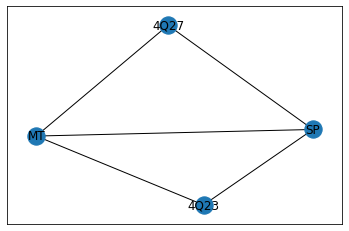

In [172]:
nx.draw_networkx(M, with_labels=True)

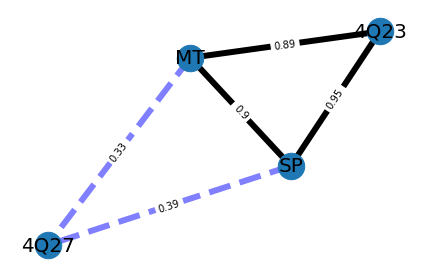

In [173]:
import matplotlib.pyplot as plt
import networkx as nx


elarge = [(u, v) for (u, v, d) in M.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in M.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(M, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(M, pos, node_size=700)

# edges
nx.draw_networkx_edges(M, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    M, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(M, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(M, "weight")
nx.draw_networkx_edge_labels(M, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# Make Rolling WIndow over MT and SP books

In [22]:
# first select lex types that vary

var_lex_typ = {}
mt_sp_gen = dat[(dat.scroll.isin(['MT', 'SP'])) & (dat.book == matching_book)]

for lex, typ in set(zip(mt_sp_gen.lex, mt_sp_gen.type)):
    lt_df = mt_sp_gen[(mt_sp_gen.lex == lex) & (mt_sp_gen.type == typ)]
    if len(set(lt_df.has_vowel_letter)) > 1:
        var_lex_typ[(lex, typ)] = lt_df

gen = pd.concat(var_lex_typ).sort_values(by='tf_id')

In [24]:
all_means = []
all_equal_matches = []

matching_manuscripts_gen = ['MT', 'SP']

all_mater_datasets = {}


matching_ids = all_match_dicts[(('MT', matching_book), ('SP', matching_book))]
man_data = gen[gen.scroll == 'MT']
man2_data = gen[gen.scroll == 'SP']

queue = deque(maxlen=100)
matches_queue= deque(maxlen=100)
for _, row in man_data.iterrows():
    tf_id, lex, typ, has_vl = row.tf_id, row.lex, row.type, row.has_vowel_letter
    
    scr = row.scroll
    if scr == 'SP':
        tf_id = tf_id - 100000
    matching_tf_id = matching_ids.get(tf_id, None)

    if not matching_tf_id:
        continue
    
    matching_tf_id = matching_tf_id + 100000
                
    man2_row = man2_data[(man2_data.tf_id == matching_tf_id) & (man2_data.lex == lex) & (man2_data.type == typ)]
                    
    if not man2_row.shape[0]:
         continue
    has_vl2 = man2_row.has_vowel_letter.iloc[0]
                
    diff = has_vl - has_vl2
    queue.append(diff)
    if has_vl == has_vl2:
        matches_queue.append(1)
    else:
        matches_queue.append(0)
    
    all_means.append(np.mean(queue))
    all_equal_matches.append(np.mean(matches_queue))
    
    if np.mean(queue) < -0.3:
        print(row.book, row.chapter, row.verse)
            

Genesis 1 14
Genesis 1 16
Genesis 1 16
Genesis 27 36
Genesis 27 38
Genesis 27 39
Genesis 27 40
Genesis 27 42
Genesis 27 43
Genesis 28 4
Genesis 28 9
Genesis 28 11
Genesis 28 11
Genesis 28 11
Genesis 28 14
Genesis 28 16
Genesis 28 17
Genesis 28 19
Genesis 28 21
Genesis 29 2
Genesis 29 3
Genesis 29 6
Genesis 29 6
Genesis 29 7
Genesis 29 7
Genesis 29 9
Genesis 29 11
Genesis 29 13
Genesis 29 16
Genesis 29 19
Genesis 29 22
Genesis 29 26
Genesis 29 27
Genesis 29 30
Genesis 29 33
Genesis 29 34
Genesis 29 35
Genesis 30 1
Genesis 30 6
Genesis 30 7
Genesis 30 8
Genesis 30 8
Genesis 30 19
Genesis 30 20
Genesis 30 25
Genesis 30 32
Genesis 30 32
Genesis 30 33
Genesis 30 35
Genesis 30 35
Genesis 30 39
Genesis 30 39
Genesis 30 40
Genesis 30 42
Genesis 30 43
Genesis 31 1
Genesis 31 2
Genesis 31 2
Genesis 31 5
Genesis 31 5
Genesis 31 8
Genesis 31 8
Genesis 31 8
Genesis 31 8
Genesis 31 10
Genesis 31 10
Genesis 31 10
Genesis 31 10
Genesis 31 10
Genesis 31 11
Genesis 31 12
Genesis 31 12
Genesis 31 12
Gene

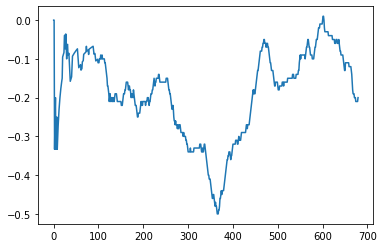

In [25]:
plt.plot(all_means)
plt.show()

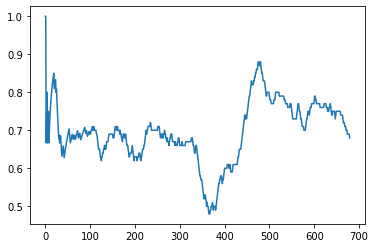

In [334]:
plt.plot(all_equal_matches)
plt.show()

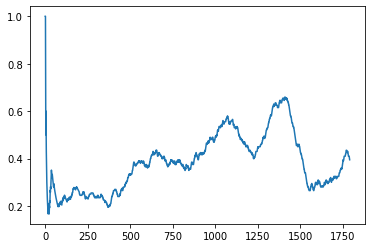

In [289]:
sp_gen = dat[(dat.scroll == 'SP') & (dat.book == 'Genesis')]

all_means = []
queue = deque(maxlen=200)

for _, row in sp_gen.iterrows():
    has_vl = row.has_vowel_letter
    queue.append(has_vl)
    all_means.append(np.mean(queue))
    
plt.plot(all_means)
plt.show()

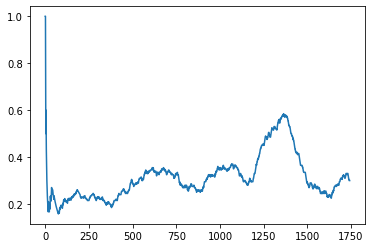

In [290]:
sp_gen = dat[(dat.scroll == 'MT') & (dat.book == 'Genesis')]

all_means = []
queue = deque(maxlen=200)

for _, row in sp_gen.iterrows():
    has_vl = row.has_vowel_letter
    queue.append(has_vl)
    all_means.append(np.mean(queue))
    
plt.plot(all_means)
plt.show()

In [307]:
mt_verses = all_books.data[('MT', 'Genesis')].verse_text_dict
sp_verses = all_books.data[('SP', 'Genesis')].verse_text_dict

In [310]:
from Levenshtein import distance

In [330]:
mean_dists = []
dist_queue = deque(maxlen=100)
for section, mt_text in mt_verses.items():
    sp_text = sp_verses[section]
    dist = distance(mt_text, sp_text)
    if dist > 20:
        continue
    dist_queue.append(dist)
    mean_dist = np.mean(dist_queue)
    mean_dists.append(mean_dist)
    #print(dist)
    if  mean_dist > 4:
        print(section, dist, mean_dist)
        print(mt_text)
        print(sp_text)
    

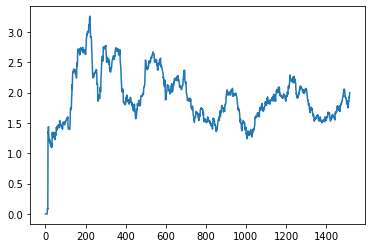

In [331]:
plt.plot(mean_dists)
plt.show()

In [53]:
man_data = gen[gen.scroll == 'MT']
lex_types_means = man_data.groupby(['lex', 'type'])['has_vowel_letter'].mean()
man_data = man_data.merge(lex_types_means, how='left', on=['lex', 'type'])
man_data['has_vowel_diff'] = man_data.has_vowel_letter_x - man_data.has_vowel_letter_y

man2_data = gen[gen.scroll == 'SP']
lex_types_means = man2_data.groupby(['lex', 'type'])['has_vowel_letter'].mean()
man2_data = man2_data.merge(lex_types_means, how='left', on=['lex', 'type'])
man2_data['has_vowel_diff'] = man2_data.has_vowel_letter_x - man2_data.has_vowel_letter_y

man2_data.columns

Index(['tf_id', 'scroll', 'book', 'chapter', 'verse', 'lex', 'g_cons', 'stem',
       'pattern', 'pattern_g_cons', 'vs', 'vt', 'nu', 'gn', 'ps', 'sp', 'prs',
       'nme', 'hloc', 'prefix', 'rec_signs', 'cor_signs', 'heb_g_cons',
       'other_vowel_ending', 'line', 'column', 'has_prs', 'has_prefix',
       'has_hloc', 'has_nme', 'rec_signs_stem', 'cor_signs_stem', 'type',
       'vowel_letter', 'has_vowel_letter_x', 'neigh_vowel_letter',
       'has_vowel_letter_y', 'has_vowel_diff'],
      dtype='object')

In [81]:
all_means = []
all_equal_matches = []
all_diff_means = []

matching_manuscripts_gen = ['MT', 'SP']

all_mater_datasets = {}


matching_ids = all_match_dicts[(('MT', matching_book), ('SP', matching_book))]
#man_data = gen[gen.scroll == 'MT']
#man2_data = gen[gen.scroll == 'SP']

man_data = gen[gen.scroll == 'MT']
lex_types_means = man_data.groupby(['lex', 'type'])['has_vowel_letter'].mean()
man_data = man_data.merge(lex_types_means, how='left', on=['lex', 'type'])
man_data['has_vowel_diff'] = man_data.has_vowel_letter_x - man_data.has_vowel_letter_y

man2_data = gen[gen.scroll == 'SP']
lex_types_means = man2_data.groupby(['lex', 'type'])['has_vowel_letter'].mean()
man2_data = man2_data.merge(lex_types_means, how='left', on=['lex', 'type'])
man2_data['has_vowel_diff'] = man2_data.has_vowel_letter_x - man2_data.has_vowel_letter_y

max_len = 50
queue = deque(maxlen=max_len)
matches_queue= deque(maxlen=max_len)
diff_queue = deque(maxlen=max_len)
for _, row in man_data.iterrows():
    tf_id, lex, typ, has_vl = row.tf_id, row.lex, row.type, row.has_vowel_letter_x
    
    scr = row.scroll
    if scr == 'SP':
        tf_id = tf_id - 100000
    matching_tf_id = matching_ids.get(tf_id, None)

    if not matching_tf_id:
        continue
    
    matching_tf_id = matching_tf_id + 100000
                
    man2_row = man2_data[(man2_data.tf_id == matching_tf_id) & (man2_data.lex == lex) & (man2_data.type == typ)]
                    
    if not man2_row.shape[0]:
         continue
    has_vl2 = man2_row.has_vowel_letter_x.iloc[0]
                
    diff = has_vl - has_vl2
    queue.append(diff)
    
    if has_vl == has_vl2:
        matches_queue.append(1)
    else:
        matches_queue.append(0)
        
    print(row.chapter, row.has_vowel_letter_y, man2_row.has_vowel_letter_y.iloc[0])
    diff_diff = row.has_vowel_diff - man2_row.has_vowel_diff.iloc[0]
    diff_queue.append(diff_diff)
    all_diff_means.append(np.mean(diff_queue))
    
    
    all_means.append(np.mean(queue))
    all_equal_matches.append(np.mean(matches_queue))
    
    if np.mean(diff_queue) < -0.3:
        print(row.book, row.chapter, row.verse)
            

1 0.8936170212765957 1.0
1 0.8888888888888888 1.0
1 0.6 1.0
1 0.8333333333333334 0.8333333333333334
1 0.6 1.0
1 0.6 1.0
1 0.48484848484848486 0.6571428571428571
1 0.6 1.0
1 0.48484848484848486 0.6571428571428571
1 0.6 1.0
1 0.48484848484848486 0.6571428571428571
1 0.71875 1.0
2 0.6923076923076923 1.0
2 1.0 0.5
2 0.71875 1.0
2 0.71875 1.0
2 0.71875 1.0
2 0.8888888888888888 1.0
2 0.71875 1.0
2 0.71875 1.0
2 1.0 0.0
3 0.71875 1.0
3 0.71875 1.0
3 0.0 0.6666666666666666
3 1.0 0.0
3 0.44 1.0
3 0.44 1.0
3 1.0 0.0
3 0.0 0.6666666666666666
3 0.0 0.6666666666666666
3 1.0 0.0
3 0.44 1.0
3 0.0 1.0
3 0.5 1.0
3 0.71875 1.0
3 0.8461538461538461 1.0
3 0.0 1.0
4 0.375 0.875
4 0.44 1.0
4 0.48484848484848486 0.6571428571428571
4 0.8333333333333334 0.8333333333333334
4 1.0 0.0
4 1.0 0.0
4 0.2916666666666667 1.0
4 0.44 1.0
4 0.9629629629629629 0.9818181818181818
5 0.6923076923076923 1.0
5 0.0625 0.0
5 0.0625 0.0
5 0.0625 0.0
5 0.0625 0.0
5 0.0625 0.0
5 0.0625 0.0
5 0.0625 0.0
6 0.71875 1.0
6 0.846153846153

36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.2916666666666667 1.0
36 0.11764705882352941 0.29411764705882354
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.8936170212765957 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
36 0.9767441860465116 1.0
37 0.6666666666666666 0.0
37 0.6923076923076923 1.0
37 0.0 1.0
37 0.9333333333333333 1.0
37 0.5588235294117647 0.5714285714285714
37 0.9629629629629629 0.9818181818181818
37 0.5588235294117647 0.57142857

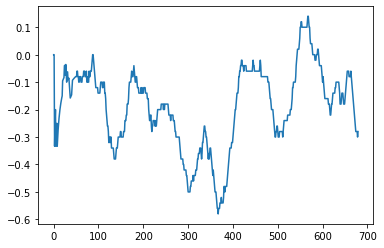

In [82]:
plt.plot(all_means)
plt.show()

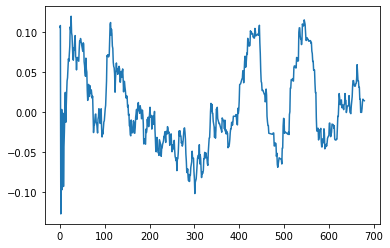

In [83]:
plt.plot(all_diff_means)
plt.show()

In [78]:
gen_data.head()

,tf_id,scroll,book,chapter,verse,lex,g_cons,stem,pattern,pattern_g_cons,...,has_hloc,has_nme,rec_signs_stem,cor_signs_stem,type,vowel_letter,has_vowel_letter_x,neigh_vowel_letter,has_vowel_letter_y,has_vowel_diff
0,151,MT,Genesis,1,9,MQWM/,MQWM,MQWM,CCMC,CCMC,...,0,0,nnnn,nnnn,last,W,1,0,0.946809,0.053191
1,235,MT,Genesis,1,13,CLJCJ/,CLJCJ,CLJC,CCMC,CCMCM,...,0,0,nnnn,nnnn,last,J,1,1,0.944444,0.055556
2,240,MT,Genesis,1,14,M>WR/,M>RT,M>R,CCC,CCCC,...,0,1,nnn,nnn,last,NaN,0,0,0.800000,-0.800000
3,257,MT,Genesis,1,14,>WT/,>TT,>T,CC,CCC,...,0,1,nn,nn,single,NaN,0,0,0.833333,-0.833333
4,269,MT,Genesis,1,15,M>WR/,M>WRT,M>WR,CCMC,CCMCC,...,0,1,nnnn,nnnn,last,W,1,0,0.800000,0.200000


In [85]:
all_means = []
all_equal_matches = []
all_diff_means = []

matching_manuscripts_gen = ['MT', 'SP']

all_mater_datasets = {}


matching_ids = all_match_dicts[(('MT', matching_book), ('SP', matching_book))]
#man_data = gen[gen.scroll == 'MT']
#man2_data = gen[gen.scroll == 'SP']

gen_data = gen[gen.scroll.isin(['SP', 'MT'])]
lex_types_means = gen_data.groupby(['lex', 'type'])['has_vowel_letter'].mean()
gen_data = gen_data.merge(lex_types_means, how='left', on=['lex', 'type'])
gen_data['has_vowel_diff'] = gen_data.has_vowel_letter_x - gen_data.has_vowel_letter_y

man_data = gen_data[gen_data.scroll == 'MT']
man2_data = gen_data[gen_data.scroll == 'SP']


max_len = 100
queue = deque(maxlen=max_len)
matches_queue= deque(maxlen=max_len)
diff_queue = deque(maxlen=max_len)
for idx, row in man_data.iterrows():
    tf_id, lex, typ, has_vl = row.tf_id, row.lex, row.type, row.has_vowel_letter_x
    
    scr = row.scroll
    if scr == 'SP':
        tf_id = tf_id - 100000
    matching_tf_id = matching_ids.get(tf_id, None)

    if not matching_tf_id:
        continue
    
    matching_tf_id = matching_tf_id + 100000
                
    man2_row = man2_data[(man2_data.tf_id == matching_tf_id) & (man2_data.lex == lex) & (man2_data.type == typ)]
                    
    if not man2_row.shape[0]:
         continue
    has_vl2 = man2_row.has_vowel_letter_x.iloc[0]
                
    diff = has_vl - has_vl2
    queue.append(diff)
    
    if has_vl == has_vl2:
        matches_queue.append(1)
    else:
        matches_queue.append(0)
      
    diff_diff = row.has_vowel_diff - man2_row.has_vowel_diff.iloc[0]
    print(row.chapter, lex, row.has_vowel_letter_x, man2_row.has_vowel_letter_x.iloc[0], diff_diff)
    
    diff_queue.append(diff_diff)
    all_diff_means.append(np.mean(diff_queue))
    
    
    all_means.append(np.mean(queue))
    all_equal_matches.append(np.mean(matches_queue))
    
    if np.mean(diff_queue) < -0.3:
        print(idx, np.mean(diff_queue), row.book, row.chapter, row.verse)
            

1 MQWM/ 1 1 0.0
1 CLJCJ/ 1 1 0.0
1 M>WR/ 0 1 -1.0
2 -0.3333333333333333 Genesis 1 14
1 >WT/ 0 0 0.0
1 M>WR/ 1 1 0.0
1 M>WR/ 0 1 -1.0
5 -0.3333333333333333 Genesis 1 16
1 GDWL/ 0 0 0.0
1 M>WR/ 1 1 0.0
1 GDWL/ 0 1 -1.0
8 -0.3333333333333333 Genesis 1 16
1 M>WR/ 1 1 0.0
1 GDWL/ 0 0 0.0
1 VWB/ 1 1 0.0
2 TWLDWT/ 1 1 0.0
2 FJX/ 1 1 0.0
2 VWB/ 1 1 0.0
2 VWB/ 1 1 0.0
2 VWB/ 1 1 0.0
2 CLJCJ/ 1 1 0.0
2 VWB/ 1 1 0.0
2 VWB/ 1 1 0.0
2 <RWM/ 1 0 1.0
3 VWB/ 1 1 0.0
3 VWB/ 1 1 0.0
3 <JRM/ 0 0 0.0
3 <JRM/ 1 0 1.0
3 QWL/ 1 1 0.0
3 QWL/ 0 1 -1.0
3 <JRM/ 1 0 1.0
3 <JRM/ 0 1 -1.0
3 <JRM/ 0 1 -1.0
3 <JRM/ 1 0 1.0
3 QWL/ 1 1 0.0
3 KTNT/ 0 1 -1.0
3 <WR=/ 1 1 0.0
3 VWB/ 1 1 0.0
3 <WLM/ 0 1 -1.0
3 KRWB/ 0 1 -1.0
4 BKR/ 0 1 -1.0
4 QWL/ 1 1 0.0
4 GDWL/ 1 1 0.0
4 >WT/ 1 1 0.0
4 KNWR/ 1 0 1.0
4 <WGB/ 1 0 1.0
4 >XWT/ 1 1 0.0
4 QWL/ 1 1 0.0
4 <WD/ 1 1 0.0
5 TWLDWT/ 1 1 0.0
5 CMNH/ 0 0 0.0
5 CMNH/ 0 0 0.0
5 CMNH/ 0 0 0.0
5 CMNH/ 0 0 0.0
5 CMNH/ 0 0 0.0
5 CMNH/ 0 0 0.0
5 CMNH/ 0 0 0.0
6 VWB/ 0 1 -1.0
6 <WLM/ 0 1 -1.0
6

32 XMWR/ 1 1 0.0
384 -0.44 Genesis 32 6
32 >DWN/ 0 0 0.0
385 -0.44 Genesis 32 6
32 PLJVH/ 1 0 1.0
386 -0.43 Genesis 32 9
32 >TWN/ 0 0 0.0
387 -0.42 Genesis 32 16
32 >DWN/ 0 0 0.0
388 -0.41 Genesis 32 19
32 CLJCJ/ 1 1 0.0
389 -0.4 Genesis 32 20
32 <WD/ 1 1 0.0
390 -0.39 Genesis 32 29
32 MQWM/ 1 1 0.0
391 -0.38 Genesis 32 31
33 >XRWN/ 0 0 0.0
392 -0.37 Genesis 33 2
33 >XRWN/ 0 0 0.0
393 -0.36 Genesis 33 2
33 >DWN/ 0 0 0.0
394 -0.36 Genesis 33 8
33 >DWN/ 0 0 0.0
395 -0.35 Genesis 33 13
33 >DWN/ 0 0 0.0
396 -0.35 Genesis 33 14
33 >DWN/ 0 0 0.0
397 -0.34 Genesis 33 14
33 >DWN/ 0 0 0.0
398 -0.34 Genesis 33 15
33 MQWM/ 1 1 0.0
399 -0.34 Genesis 33 17
34 >XWT/ 0 1 -1.0
400 -0.35 Genesis 34 13
34 >XWT/ 0 1 -1.0
401 -0.36 Genesis 34 14
34 CLJCJ/ 1 1 0.0
402 -0.35 Genesis 34 25
34 >XWT/ 1 1 0.0
403 -0.35 Genesis 34 27
34 XMWR/ 0 0 0.0
404 -0.34 Genesis 34 28
34 >XWT/ 1 1 0.0
405 -0.33 Genesis 34 31
35 MQWM/ 1 1 0.0
406 -0.32 Genesis 35 7
35 MJNQT/ 1 1 0.0
407 -0.32 Genesis 35 8
35 <WD/ 1 1 0.0
40

In [93]:
man_data[man_data.lex == 'NQD=/']

,tf_id,scroll,book,chapter,verse,lex,g_cons,stem,pattern,pattern_g_cons,...,has_hloc,has_nme,rec_signs_stem,cor_signs_stem,type,vowel_letter,has_vowel_letter_x,neigh_vowel_letter,has_vowel_letter_y,has_vowel_diff
343,16104,MT,Genesis,30,32,NQD=/,NQD,NQD,CCC,CCC,...,0,0,nnn,nnn,last,NaN,0,0,0.526316,-0.526316
344,16117,MT,Genesis,30,32,NQD=/,NQD,NQD,CCC,CCC,...,0,0,nnn,nnn,last,NaN,0,0,0.526316,-0.526316
345,16140,MT,Genesis,30,33,NQD=/,NQD,NQD,CCC,CCC,...,0,0,nnn,nnn,last,NaN,0,0,0.526316,-0.526316
347,16183,MT,Genesis,30,35,NQD=/,NQDWT,NQD,CCC,CCCMC,...,0,1,nnn,nnn,last,NaN,0,1,0.526316,-0.526316
349,16284,MT,Genesis,30,39,NQD=/,NQDJM,NQD,CCC,CCCMC,...,0,1,nnn,nnn,last,NaN,0,0,0.526316,-0.526316
358,16499,MT,Genesis,31,8,NQD=/,NQDJM,NQD,CCC,CCCMC,...,0,1,nnn,nnn,last,NaN,0,0,0.526316,-0.526316
359,16507,MT,Genesis,31,8,NQD=/,NQDJM,NQD,CCC,CCCMC,...,0,1,nnn,nnn,last,NaN,0,0,0.526316,-0.526316
365,16554,MT,Genesis,31,10,NQD=/,NQDJM,NQD,CCC,CCCMC,...,0,1,nnn,nnn,last,NaN,0,0,0.526316,-0.526316
370,16586,MT,Genesis,31,12,NQD=/,NQDJM,NQD,CCC,CCCMC,...,0,1,nnn,nnn,last,NaN,0,0,0.526316,-0.526316


In [94]:
man2_data[man2_data.lex == 'NQD=/']

,tf_id,scroll,book,chapter,verse,lex,g_cons,stem,pattern,pattern_g_cons,...,has_hloc,has_nme,rec_signs_stem,cor_signs_stem,type,vowel_letter,has_vowel_letter_x,neigh_vowel_letter,has_vowel_letter_y,has_vowel_diff
1041,521630,SP,Genesis,30,32,NQD=/,NQWD,NQWD,CCMC,CCMC,...,0,0,nnnn,nnnn,last,W,1,0,0.526316,0.473684
1042,521642,SP,Genesis,30,32,NQD=/,NQWD,NQWD,CCMC,CCMC,...,0,0,nnnn,nnnn,last,W,1,0,0.526316,0.473684
1043,521664,SP,Genesis,30,33,NQD=/,NQWD,NQWD,CCMC,CCMC,...,0,0,nnnn,nnnn,last,W,1,0,0.526316,0.473684
1045,521705,SP,Genesis,30,35,NQD=/,NQWDWT,NQWD,CCMC,CCMCMC,...,0,1,nnnn,nnnn,last,W,1,1,0.526316,0.473684
1049,521771,SP,Genesis,30,36,NQD=/,NQWDJM,NQWD,CCMC,CCMCMC,...,0,1,nnnn,nnnn,last,W,1,0,0.526316,0.473684
1052,521877,SP,Genesis,30,39,NQD=/,NQWDJM,NQWD,CCMC,CCMCMC,...,0,1,nnnn,nnnn,last,W,1,0,0.526316,0.473684
1061,522088,SP,Genesis,31,8,NQD=/,NQWDJM,NQWD,CCMC,CCMCMC,...,0,1,nnnn,nnnn,last,W,1,0,0.526316,0.473684
1062,522096,SP,Genesis,31,8,NQD=/,NQWDJM,NQWD,CCMC,CCMCMC,...,0,1,nnnn,nnnn,last,W,1,0,0.526316,0.473684
1068,522143,SP,Genesis,31,10,NQD=/,NQWDJM,NQWD,CCMC,CCMCMC,...,0,1,nnnn,nnnn,last,W,1,0,0.526316,0.473684
1073,522175,SP,Genesis,31,12,NQD=/,NQWDJM,NQWD,CCMC,CCMCMC,...,0,1,nnnn,nnnn,last,W,1,0,0.526316,0.473684


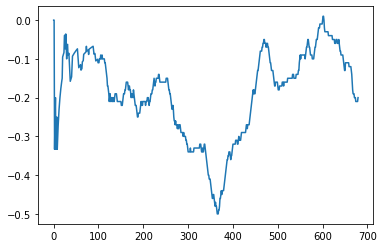

In [75]:
plt.plot(all_means)
plt.show()

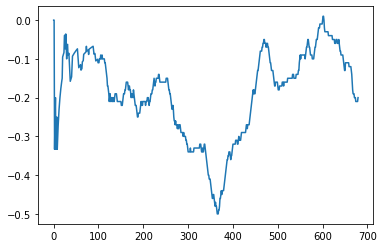

In [76]:
plt.plot(all_diff_means)
plt.show()